In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Choose paths for input data and output data
ready_path <- '../data_tmp/'
out_path <- '../out_tmp/'

# A treatment key is stored in this repository
trt = pd.read_csv('../../metadata/lt_plot_trt.csv', skiprows=2)

In [2]:
trt.head()

,plotid,n_trt,ppt_trt
0,108,0,1
1,126,0,1
2,206,0,1
3,214,0,1
4,309,0,1


In [ ]:
# Load filtered soil moisture data
# This comes from package knb-lter-jrn.210349002 on EDI
df_filt = pd.read_csv(ready_path + '/sm_qa_juntar.csv', parse_dates=True, index_col='TIMESTAMP')

In [18]:
import seaborn as sns
p = sns.diverging_palette(30, 250, l=65, center="dark", n=3)
sns.set_palette(p)
p

[(0.90499399934908, 0.5182704637470051, 0.3064196349089693),
 (0.13668746475015844, 0.14056792582310582, 0.14872962310788068),
 (0.4265534711840377, 0.6260975213663689, 0.9072715683943962)]

In [ ]:
# From the filtered timeseries, add categorical columns and create a long-form dataset
df_long = df_filt.copy()
vwccols = df_long.columns
df_long['datetime'] = df_long.index
# Melt
df_long = df_long.melt(id_vars = 'datetime', value_vars=vwccols)
df_long['depth'] = df_long.variable.str[0:4]
df_long['plotid'] = df_long.variable.str.split('_', expand=True)[1].astype(int)
df_long = df_long.merge(trt, on='plotid')

# Add some categorical columns
df_long['month'] = df_long.datetime.dt.month
df_long['year'] = df_long.datetime.dt.year
#df_long['week'] = df_long.datetime.dt.week
df_long['Treatment'] = df_long['ppt_trt'].map({1: '-80%', 3:'ambient', 5:'+80%'})

df_long.info()
df_long.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1967760 entries, 0 to 1967759
Data columns (total 10 columns):
 #   Column     Dtype         
---  ------     -----         
 0   datetime   datetime64[ns]
 1   variable   object        
 2   value      float64       
 3   depth      object        
 4   plotid     int64         
 5   n_trt      int64         
 6   ppt_trt    int64         
 7   month      int32         
 8   year       int32         
 9   Treatment  object        
dtypes: datetime64[ns](1), float64(1), int32(2), int64(3), object(3)
memory usage: 135.1+ MB


,datetime,variable,value,depth,plotid,n_trt,ppt_trt,month,year,Treatment
0,2018-07-06 00:00:00,deepVWC_101_Avg,NaN,deep,101,0,3,7,2018,ambient
1,2018-07-06 01:00:00,deepVWC_101_Avg,NaN,deep,101,0,3,7,2018,ambient
2,2018-07-06 02:00:00,deepVWC_101_Avg,NaN,deep,101,0,3,7,2018,ambient
3,2018-07-06 03:00:00,deepVWC_101_Avg,NaN,deep,101,0,3,7,2018,ambient
4,2018-07-06 04:00:00,deepVWC_101_Avg,NaN,deep,101,0,3,7,2018,ambient


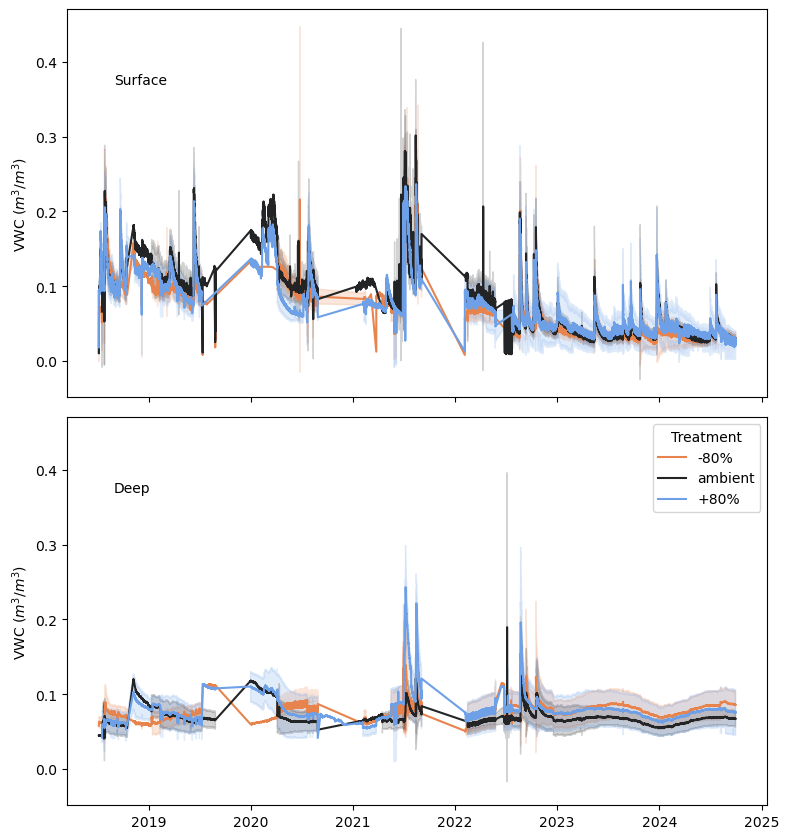

In [20]:
# Use long dataset - plot mean and CI of surface and deep water by treatment
#sns.set_palette([p[1],p[2],p[0]])
sns.set_palette(p)

fig, ax = plt.subplots(2, 1, figsize=(8,8.5), sharey=True, sharex=True)
a1 = sns.lineplot(data=df_long[df_long.depth=='surf'], ax=ax[0], x='datetime', y='value',
                  hue="Treatment", errorbar='sd', legend=False, hue_order=['-80%', 'ambient','+80%'])
a2 = sns.lineplot(data=df_long[df_long.depth=='deep'], ax=ax[1], x="datetime", y='value',
                  hue="Treatment", errorbar='sd', legend=True, hue_order=['-80%', 'ambient','+80%'])
#a3 = sns.lineplot(data=df_long, ax=ax[2], x="datetime", y='+80%',
#                  hue="depth", errorbar='sd', legend=True)

a1.set(xlabel=None)
a1.set(ylabel="VWC ($m^3/m^3$)")
a2.set(ylabel="VWC ($m^3/m^3$)")
#a3.set(ylabel="VWC ($m^3/m^3$)")
#a3.set(xlabel='Date')
a2.set(xlabel=None)
xaxlab = pd.to_datetime('2018-8-30')
a1.text(xaxlab, 0.37, 'Surface' )
a2.text(xaxlab, 0.37, 'Deep' )
#a3.text(xaxlab, 0.37, '+80%' )
plt.tight_layout()


Text(0.25, 0.22, 'Deep soil')

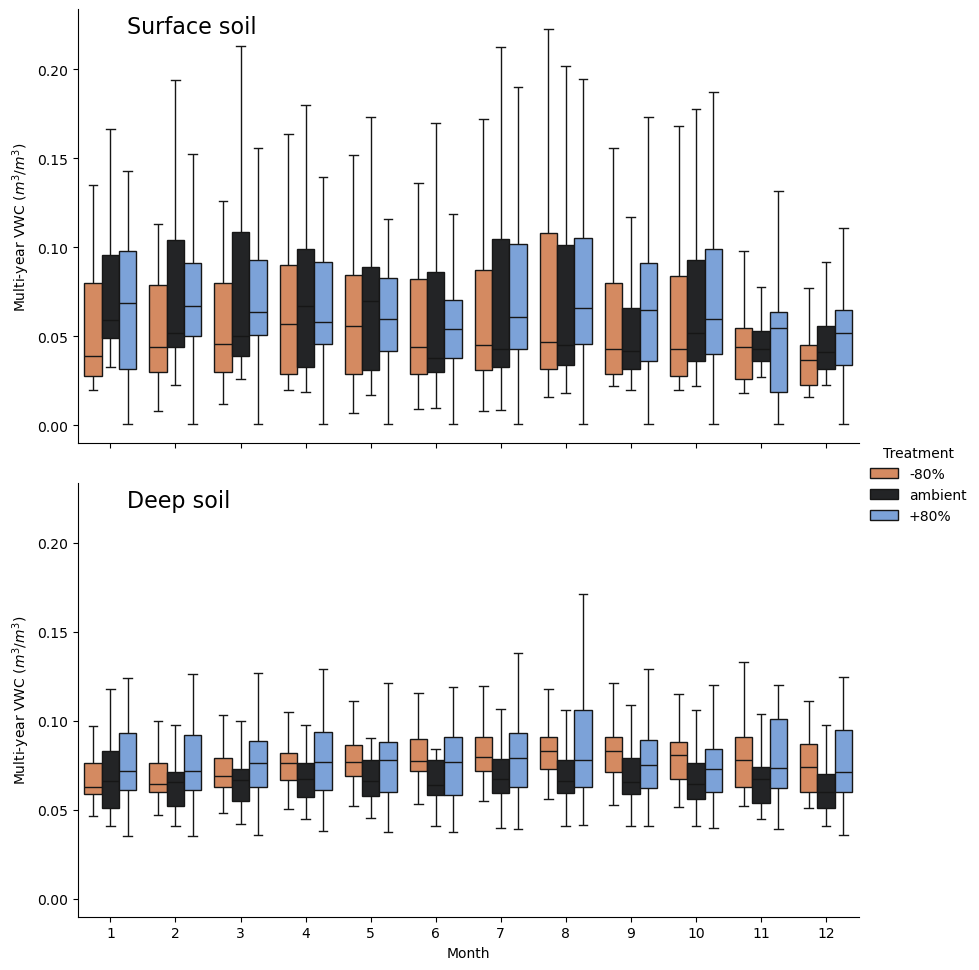

In [21]:
# Boxplots showing distribution in each month across all years
g = sns.catplot(data=df_long, x='month', y='value', hue='Treatment', row='depth', kind='box',
                errorbar='sd', legend=True, showfliers=False, aspect=1.75,
                hue_order=['-80%', 'ambient','+80%'], row_order=['surf','deep'])
g.set(ylabel="Multi-year VWC ($m^3/m^3$)", xlabel='Month')
g.set_titles('')
g.axes[0,0].text(0.25, 0.22,'Surface soil', fontsize=16)
g.axes[1,0].text(0.25, 0.22,'Deep soil', fontsize=16)

#plt.savefig(outpath + '/figs/sm_boxp_depth_trt.png', dpi=300, facecolor='w')

In [22]:
# Get a growing season subset of the long dataframe
test = np.where((df_long.month > 6) & (df_long.month < 10))
df_long_gs = df_long.loc[test]
# Add day
df_long_gs['day'] = df_long_gs.datetime.dt.day
df_long_gs.head()

,datetime,variable,value,depth,plotid,n_trt,ppt_trt,month,year,Treatment,day
0,2018-07-06 00:00:00,deepVWC_101_Avg,NaN,deep,101,0,3,7,2018,ambient,6
1,2018-07-06 01:00:00,deepVWC_101_Avg,NaN,deep,101,0,3,7,2018,ambient,6
2,2018-07-06 02:00:00,deepVWC_101_Avg,NaN,deep,101,0,3,7,2018,ambient,6
3,2018-07-06 03:00:00,deepVWC_101_Avg,NaN,deep,101,0,3,7,2018,ambient,6
4,2018-07-06 04:00:00,deepVWC_101_Avg,NaN,deep,101,0,3,7,2018,ambient,6


Text(0, 0.5, 'Growing season average VWC\n(JAS, $m^3/m^3$)')

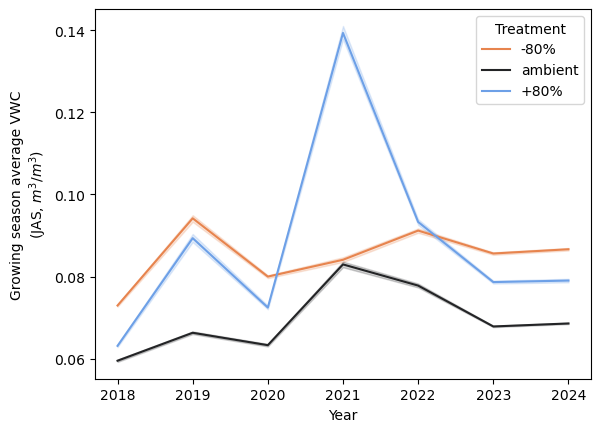

In [23]:
# Look at average of growing season VWC over the years, by treatment
# Note that these are small confidence intervals because all values (hourly)
# are used
ax = sns.lineplot(data=df_long_gs[df_long_gs.depth=='deep'],
                 x='year', y='value', hue='Treatment', 
                hue_order=['-80%', 'ambient','+80%'])
ax.set_xlabel('Year')
ax.set_ylabel('Growing season average VWC\n(JAS, $m^3/m^3$)')

#plt.savefig(outpath + '/figs/fig4_absVWC.jpg', dpi=400, facecolor='w')

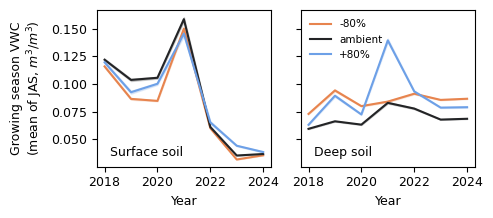

In [24]:
# Same figure as above, but with deep value too.
# CI calculated on full timeseries
plt.rcParams.update({'font.size':9})
fig, ax = plt.subplots(1, 2, figsize=(5.0,2.25), sharey=True, sharex=False)

ax0 = sns.lineplot(data=df_long_gs[df_long_gs.depth=='surf'],
                ax = ax[0], legend=False, errorbar=('ci', 95),
                x='year', y='value', hue='Treatment', 
                hue_order=['-80%', 'ambient','+80%'])
ax0.set_xlabel('Year')
ax0.set_ylabel('Growing season VWC\n(mean of JAS, $m^3/m^3$)')
ax0.text(2018.2, 0.035, 'Surface soil' )

ax1 = sns.lineplot(data=df_long_gs[df_long_gs.depth=='deep'],
                ax = ax[1], errorbar=('ci', 95),
                x='year', y='value', hue='Treatment', 
                hue_order=['-80%', 'ambient','+80%'])
ax1.set_xlabel('Year')
ax1.legend(loc=2, prop={'size': 7.5}, framealpha=0.0)
ax1.text(2018.2, 0.035, 'Deep soil' )
plt.tight_layout()

#plt.savefig(out_path + '/figs/fig4_absVWC_2layer_cism.jpg', dpi=400, facecolor='w')
#plt.savefig(out_path + '/figs/fig4_absVWC_2layer_cism.pdf', dpi=400, facecolor='w')

In [25]:
# Take the long timeseries, group and calculate annual means
df_long_gs.head()
gby = df_long_gs.groupby(['year','plotid', 'depth', 'Treatment'])
means = gby.mean(numeric_only=True).reset_index()
means.head()

,year,plotid,depth,Treatment,value,n_trt,ppt_trt,month,day
0,2018,101,deep,ambient,0.055918,0.0,3.0,8.045977,16.574713
1,2018,101,surf,ambient,0.105263,0.0,3.0,8.045977,16.574713
2,2018,108,deep,-80%,0.066472,0.0,1.0,8.045977,16.574713
3,2018,108,surf,-80%,0.108671,0.0,1.0,8.045977,16.574713
4,2018,124,deep,ambient,0.065708,0.0,3.0,8.045977,16.574713


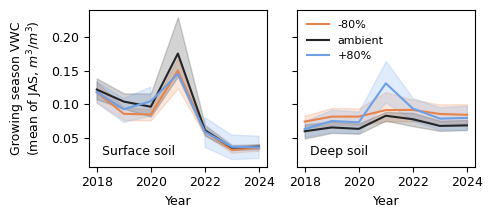

In [27]:
# Now plot the means dataframe, which gives proper CIs
plt.rcParams.update({'font.size':9})
fig, ax = plt.subplots(1, 2, figsize=(5.0,2.25), sharey=True, sharex=False)

ax0 = sns.lineplot(data=means[means.depth=='surf'],
                ax = ax[0], legend=False, errorbar=('ci', 95),
                x='year', y='value', hue='Treatment', 
                hue_order=['-80%', 'ambient','+80%'])
ax0.set_xlabel('Year')
ax0.set_ylabel('Growing season VWC\n(mean of JAS, $m^3/m^3$)')
ax0.text(2018.2, 0.025, 'Surface soil' )

ax1 = sns.lineplot(data=means[means.depth=='deep'],
                ax = ax[1], errorbar=('ci', 95),
                x='year', y='value', hue='Treatment', 
                hue_order=['-80%', 'ambient','+80%'])
ax1.set_xlabel('Year')
ax1.legend(loc=2, prop={'size': 8}, framealpha=0.0)
ax1.text(2018.2, 0.025, 'Deep soil' )
plt.tight_layout()

#plt.savefig(out_path + '/figs/fig4_absVWC_2layer_cilg.jpg', dpi=400, facecolor='w')
#plt.savefig(out_path + '/figs/fig4_absVWC_2layer_cilg.pdf', dpi=400, facecolor='w')